# 0.0. IMPORTS

In [3]:
import math
import pickle
import pandas as pd
import numpy  as np
import inflection
import datetime as dt
import seaborn as sns

import xgboost as xgb

from scipy                          import stats as ss
from boruta                         import BorutaPy
from matplotlib                     import pyplot as plt
from IPython.core.display           import HTML
from IPython.display                import Image

from sklearn.metrics                import mean_absolute_error, mean_squared_error
from sklearn.ensemble               import RandomForestRegressor
from sklearn.linear_model           import LinearRegression, Lasso
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder




ModuleNotFoundError: No module named 'xgboost'

## 0.1. Helper Functions

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 )):
        if verbose:  
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )
        
        # filtering dataset
        training= x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date','sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1 (yvalidation), np.expm1(yhat) )
        
        # store performance of each kfol iteraction
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame({' Model Name ': model_name,
                         'MAE CV' : np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                         'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                         'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str ) } , index=[0] )

# abs -> absoluto, tira o sinal negativo

def mean_percentage_error( y, yhat ):
    return np.mean( ( ( y - yhat ) / y ) )

# sklearn.metrics já possui essa função.
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

# y = valores verdadeiros
# yhat = valores da predicao

def ml_error( model_name, y , yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

# calcular Cramer : valor de Cramer vai de 0 a 1
# cm -> confusion matrix

# Ordem dos valores: teste de chi2 (baseado no Pearson), p-value, grau de liberdade, tabela de frequencia
# r = rows k = columns

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [40,18]
    plt.rcParams['font.size'] = 18
    
    display( HTML('<style>.container{width:100% !important; }</style'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


NameError: name 'HTML' is not defined

## 0.2. Loading data

In [8]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [9]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
596969,115,7,2014-01-12,0,0,0,0,0,0,d,c,5740.0,4.0,2007.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0. PASSO 01 : DESCRICAO DOS DADOS

In [10]:
# Sempre fazer uma cópia toda vez que trocar de seção

df1 = df_raw.copy()

## 1.1. Rename columns

In [1]:
df1.columns

NameError: name 'df1' is not defined

In [12]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename
df1.columns = cols_new

In [13]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [16]:
df1['date'] = pd.to_datetime( df1['date'] )

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

-  **3 Maneiras de lidar com NA** :
    - Excluir as linhas que possuem NA -> pode prejudicar o modelo, informação jogada fora.
    - Uso de algoritmos para preenchimento -> quando nao tem informação de negócio
    - Entendendo o negócio -> Pq o NA está aqui?

## 1.5. Fillout NA

In [19]:
df1['competition_distance'].max()

200000.0

In [20]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [17]:
df1.sample(5).T

,132791,448973,159640,422566,758263
store,107,414,196,767,849
day_of_week,5,7,2,3,3
date,2015-04-03 00:00:00,2014-05-25 00:00:00,2015-03-10 00:00:00,2014-06-18 00:00:00,2013-08-21 00:00:00
sales,0,0,4374,6206,5673
customers,0,0,619,641,728
open,0,0,1,1,1
promo,1,0,0,1,0
state_holiday,b,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,d,c,a,c


## 1.6. Change Types

In [44]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [24]:
num_attributes = df1.select_dtypes( include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64','int32', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [19]:
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersin = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


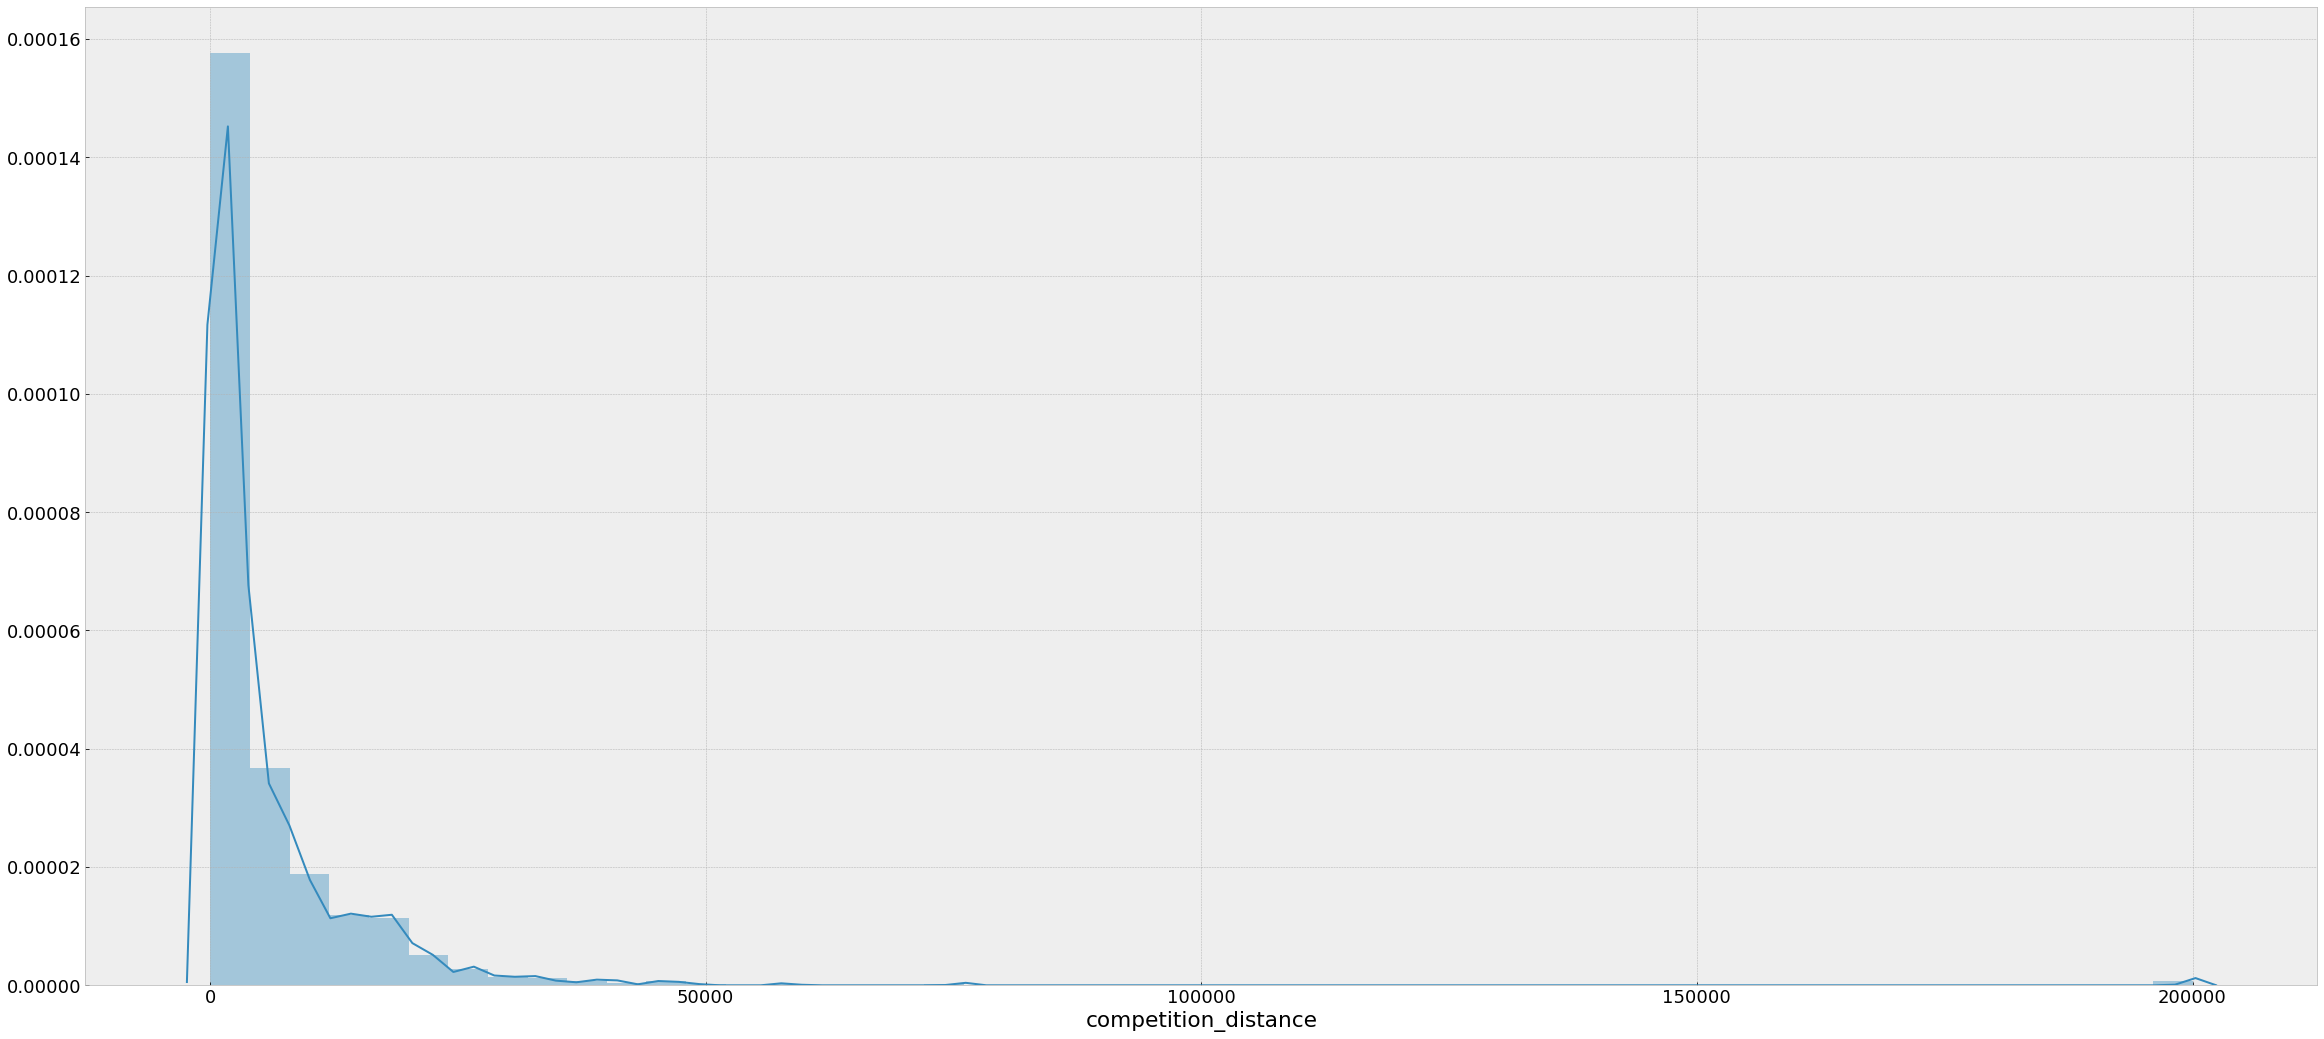

In [49]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

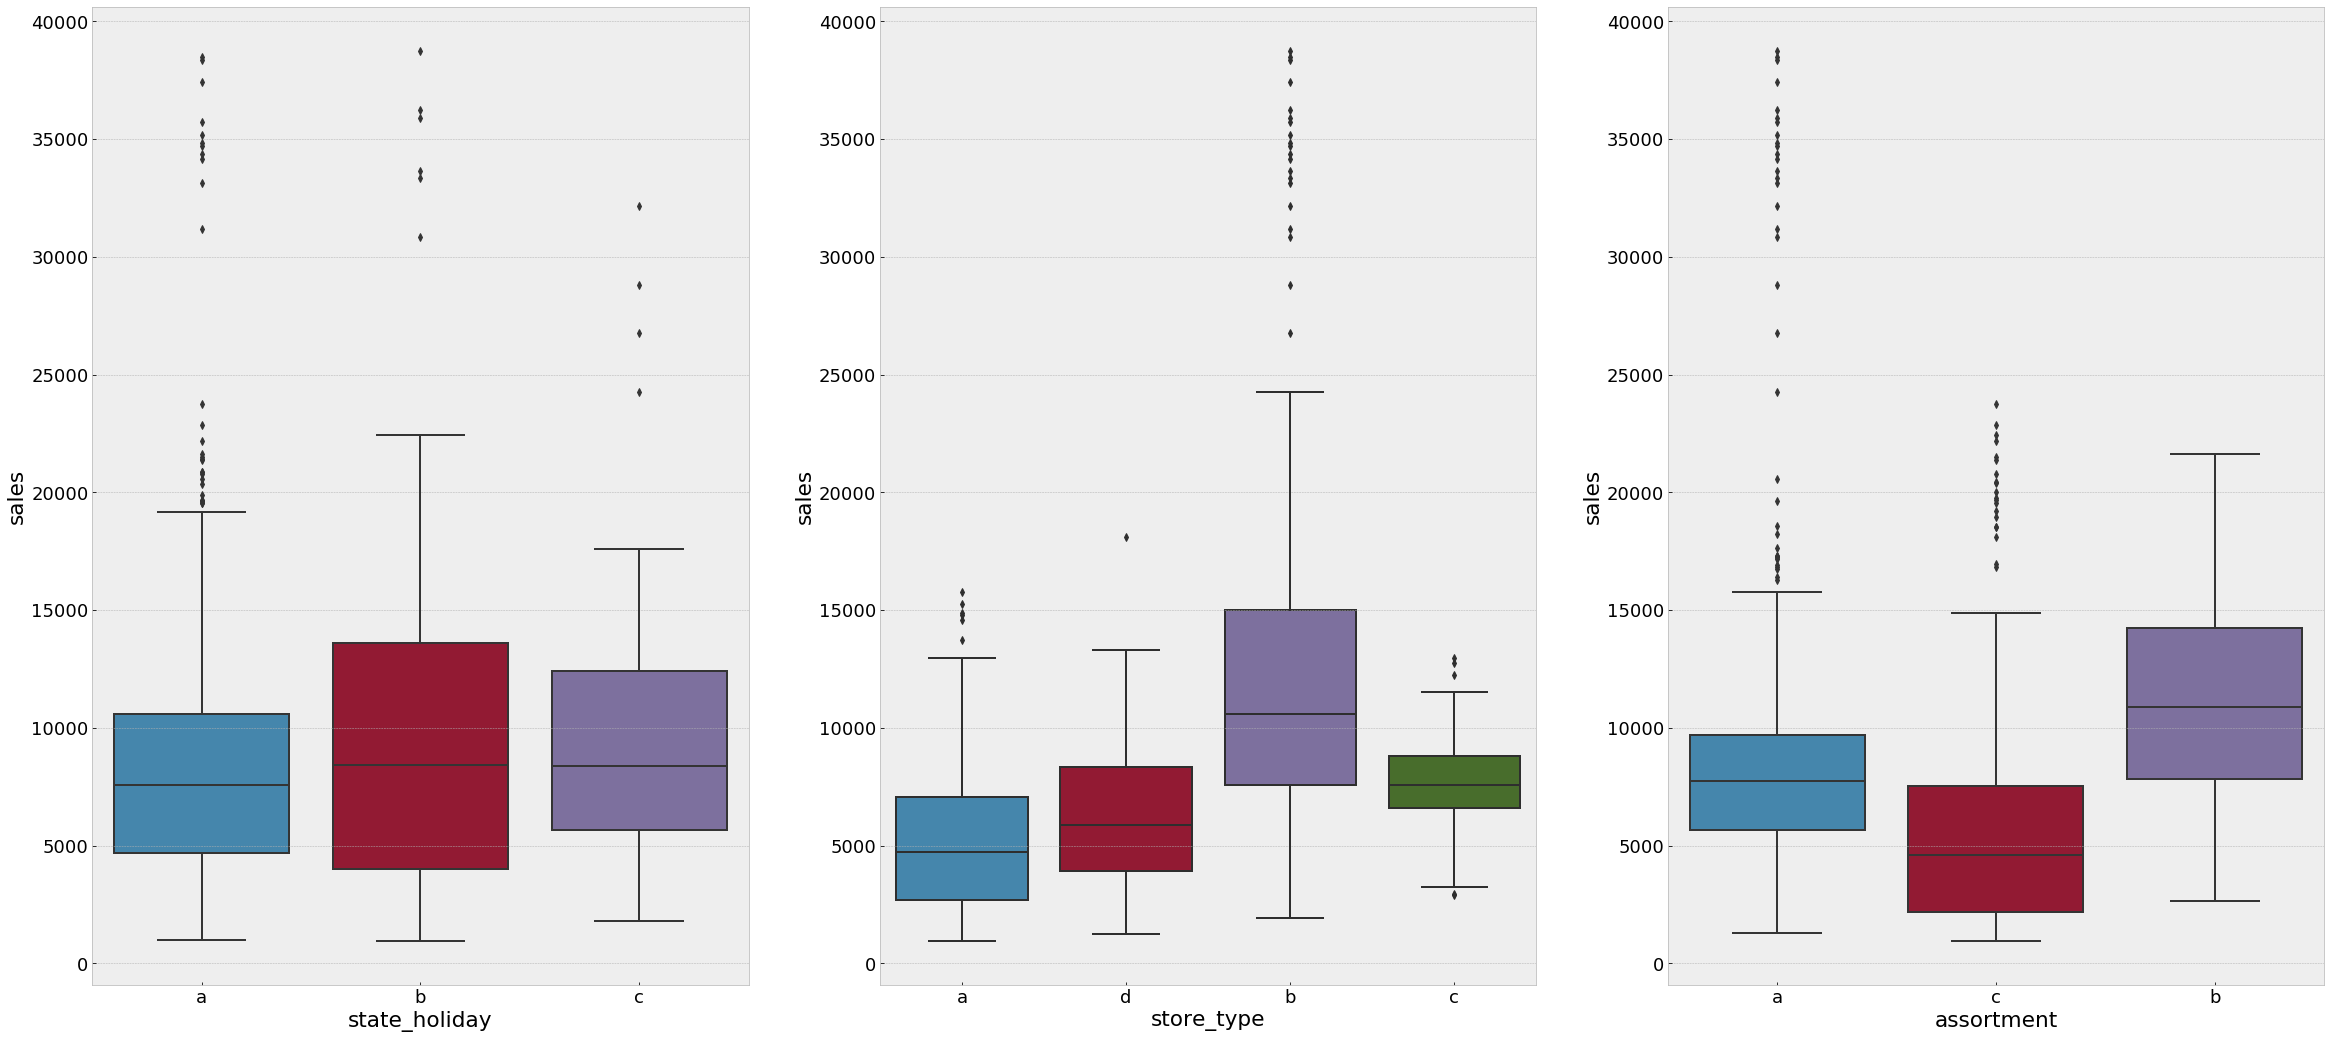

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x = 'state_holiday', y = 'sales' , data = aux1)

plt.subplot(1,3,2)
sns.boxplot( x = 'store_type', y = 'sales' , data = aux1)

plt.subplot(1,3,3)
sns.boxplot( x = 'assortment', y = 'sales' , data = aux1)

# 2.0 PASSO 02 : FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

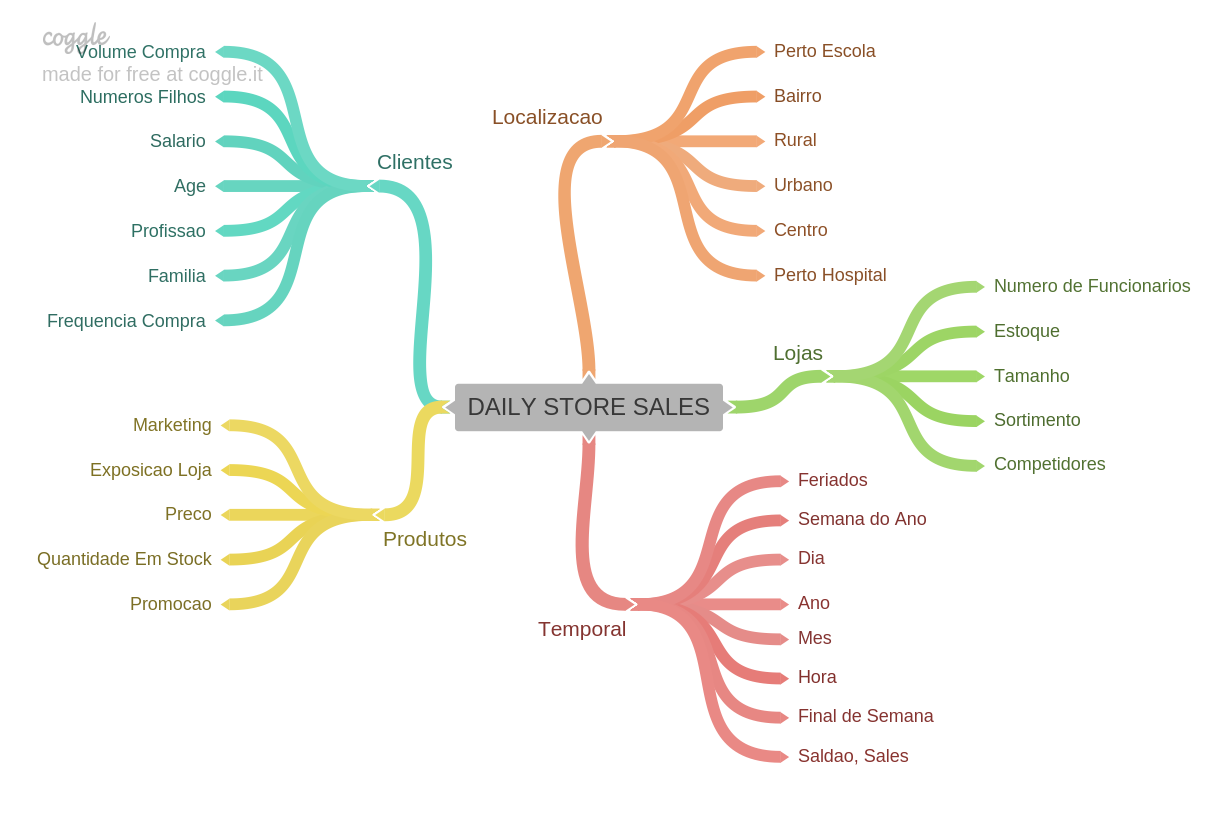

In [22]:
Image('img/MindMapHypothesis.png')

## 2.1. Criacao das Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com mais dias de promoção deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [46]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) / 7).apply( lambda x: x.days ).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x :'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 : FILTRAGEM DE VARIÁVEIS

In [47]:
df3 = df2.copy()

In [36]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [48]:
# vendas cujas lojas estavam abertas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [49]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

# 4.0. PASSO 04 : ANÁLISE EXPLORATÓRIA DOS DADOS

In [113]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1 Response Variable

In [ ]:
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

In [ ]:
num_attributes.hist( bins = 25 );

In [ ]:
# Comentarios
- Nota-se uma alta concentração de concorrentes próximos, em uma distribuição com skew positiva e alta kurtosis

- Importante ressaltar que houve um maior número de vendas quando não havia nenhuma promoção ativa.

- Do contrário do que se pensa, não há uma diferença grande no número de vendas por dia da semana, tampouco em relação ao efeito de estar participando ou não da promoção 2

- É válido entender os motivos de negócio que levaram ao aumento no número de vendas nas lojas que iniciaram a promoção 2 no ano de 2013.



### 4.1.3. Categorical Variable

In [51]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

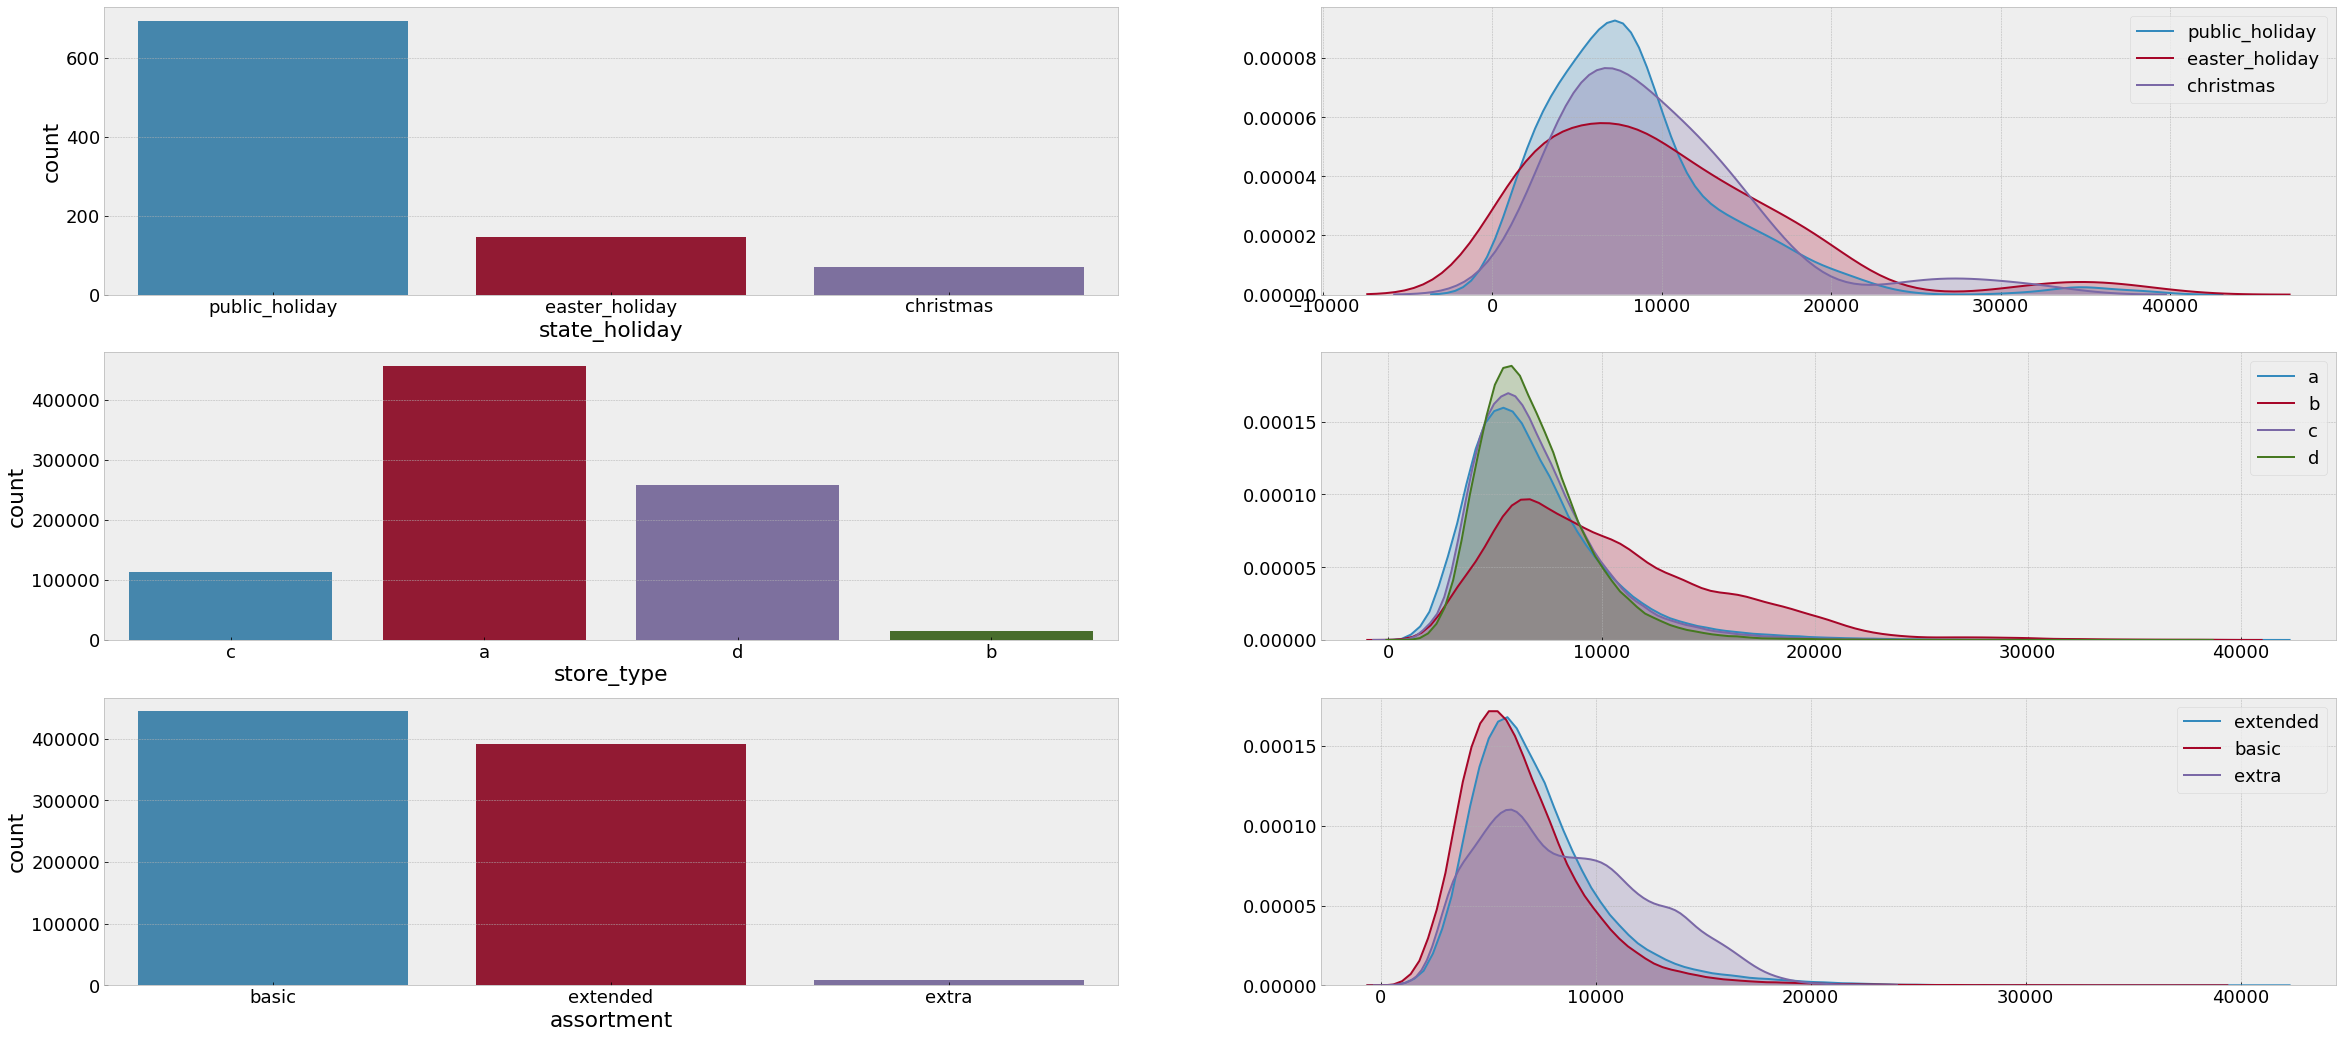

In [77]:
# state_holiday
plt.subplot( 3,2,1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3,2,2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

# store_type
plt.subplot( 3,2,3 )
sns.countplot(df4['store_type'])

plt.subplot( 3,2,4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)


# assortment
plt.subplot( 3,2,5 )
sns.countplot(df4['assortment'])

plt.subplot( 3,2,6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA**: Lojas com maior sortimentos vendem **MENOS**.

In [ ]:
# Lojas com maior sortimento vendem menos!
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data=aux1);

# Isso eh devido a algum fato histórico? Não!
aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index= 'year_week', columns= 'assortment', values='sales').plot()

# O comportamento da extra pode passar a impressao de estar diferente. Se plotarmos apenas ela, tiramos essa dúvida.
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns= 'assortment',values= 'sales').plot()

In [ ]:
aux3.head()

In [ ]:
aux2.head()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA**: Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS**.

In [ ]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data= aux1);

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000))
# pd.cut : pega variavel original e pega os bins criados
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned',y= 'sales', data=aux2);
plt.xticks( rotation = 90);

# Correlaçao : Quanto mais próximo de 0, menor a correlação. No caso, quanto maior a distância, menor as vendas.
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method= 'pearson' ), annot= True);
#bottom, top = x.get_ylim()
#x.set_ylim( bottom+0.5, top-0.5);

In [ ]:
aux2.sample(4)

### H3. Lojas com mais dias de promoção deveriam vender mais.
**FALSA**: Lojas com **COMPETIDORES À MAIS TEMPO** vendem **MENOS**.

In [ ]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x= 'competition_time_month', y = 'sales' , data= aux2);
plt.xticks(rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot( x= 'competition_time_month', y = 'sales' , data= aux2);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method= 'pearson'), annot = True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA**: Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

In [ ]:
df4.head()

In [ ]:
## promo time week negativo -> venda ocorreu durante a promocao 1
## Promo time week positivo -> venda ocorreu durante a promoção extendida

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data = aux2);
plt.xticks( rotation = 90);


plt.subplot( grid[0,1] )
sns.regplot( x ='promo_time_week', y = 'sales', data= aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data = aux3);
plt.xticks( rotation = 90);

plt.subplot( grid[1,1] )
sns.regplot( x ='promo_time_week', y = 'sales', data= aux3);

plt.subplot( grid[:,2])
sns.heatmap( aux1.corr( method= 'pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>


In [ ]:
## ON HOLD para o próximo ciclo por ser muito parecida com a H4.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: Lojas com mais promocoes consecutivas vendem menos.

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales',ascending=True)

## Nao ha vantagem em participar da promocao extendida a primeira vista

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax );

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA**: Lojas abertas durante o feriado de Natal vendem MENOS.

In [ ]:
plt.subplot( 1, 2, 1 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y= 'sales', hue='state_holiday', data=aux2);


### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: Lojas vendem menos ao longo dos anos.

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'year',y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'year',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: Lojas vendem menos no segundo semestre do ano

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
# aux1 = df4[df4['year'] < 2015][['month','sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'month',y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'month',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

In [ ]:
# Dados a partir de agosto de 2015 podem enviesar o modelo
df4[['date','year','month','sales']].sort_values(['year','month'], ascending=False)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**: Lojas vendem mais deppois do dia 10 de cada mês

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot(x= 'day',y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
sns.regplot(x= 'day',y='sales', data=aux1);

plt.subplot( 2, 2, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

aux1['before_after'] = aux1['day'].apply( lambda x : 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot(x ='before_after', y= 'sales', data=aux2);

In [ ]:

aux1.sample()

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem MENOS aos finais de semana

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'day_of_week',y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'day_of_week',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method= 'pearson'), annot= True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**: Lojas vendem menos durante os feriados escolares, except os meses de Julho e Agosto.

In [78]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

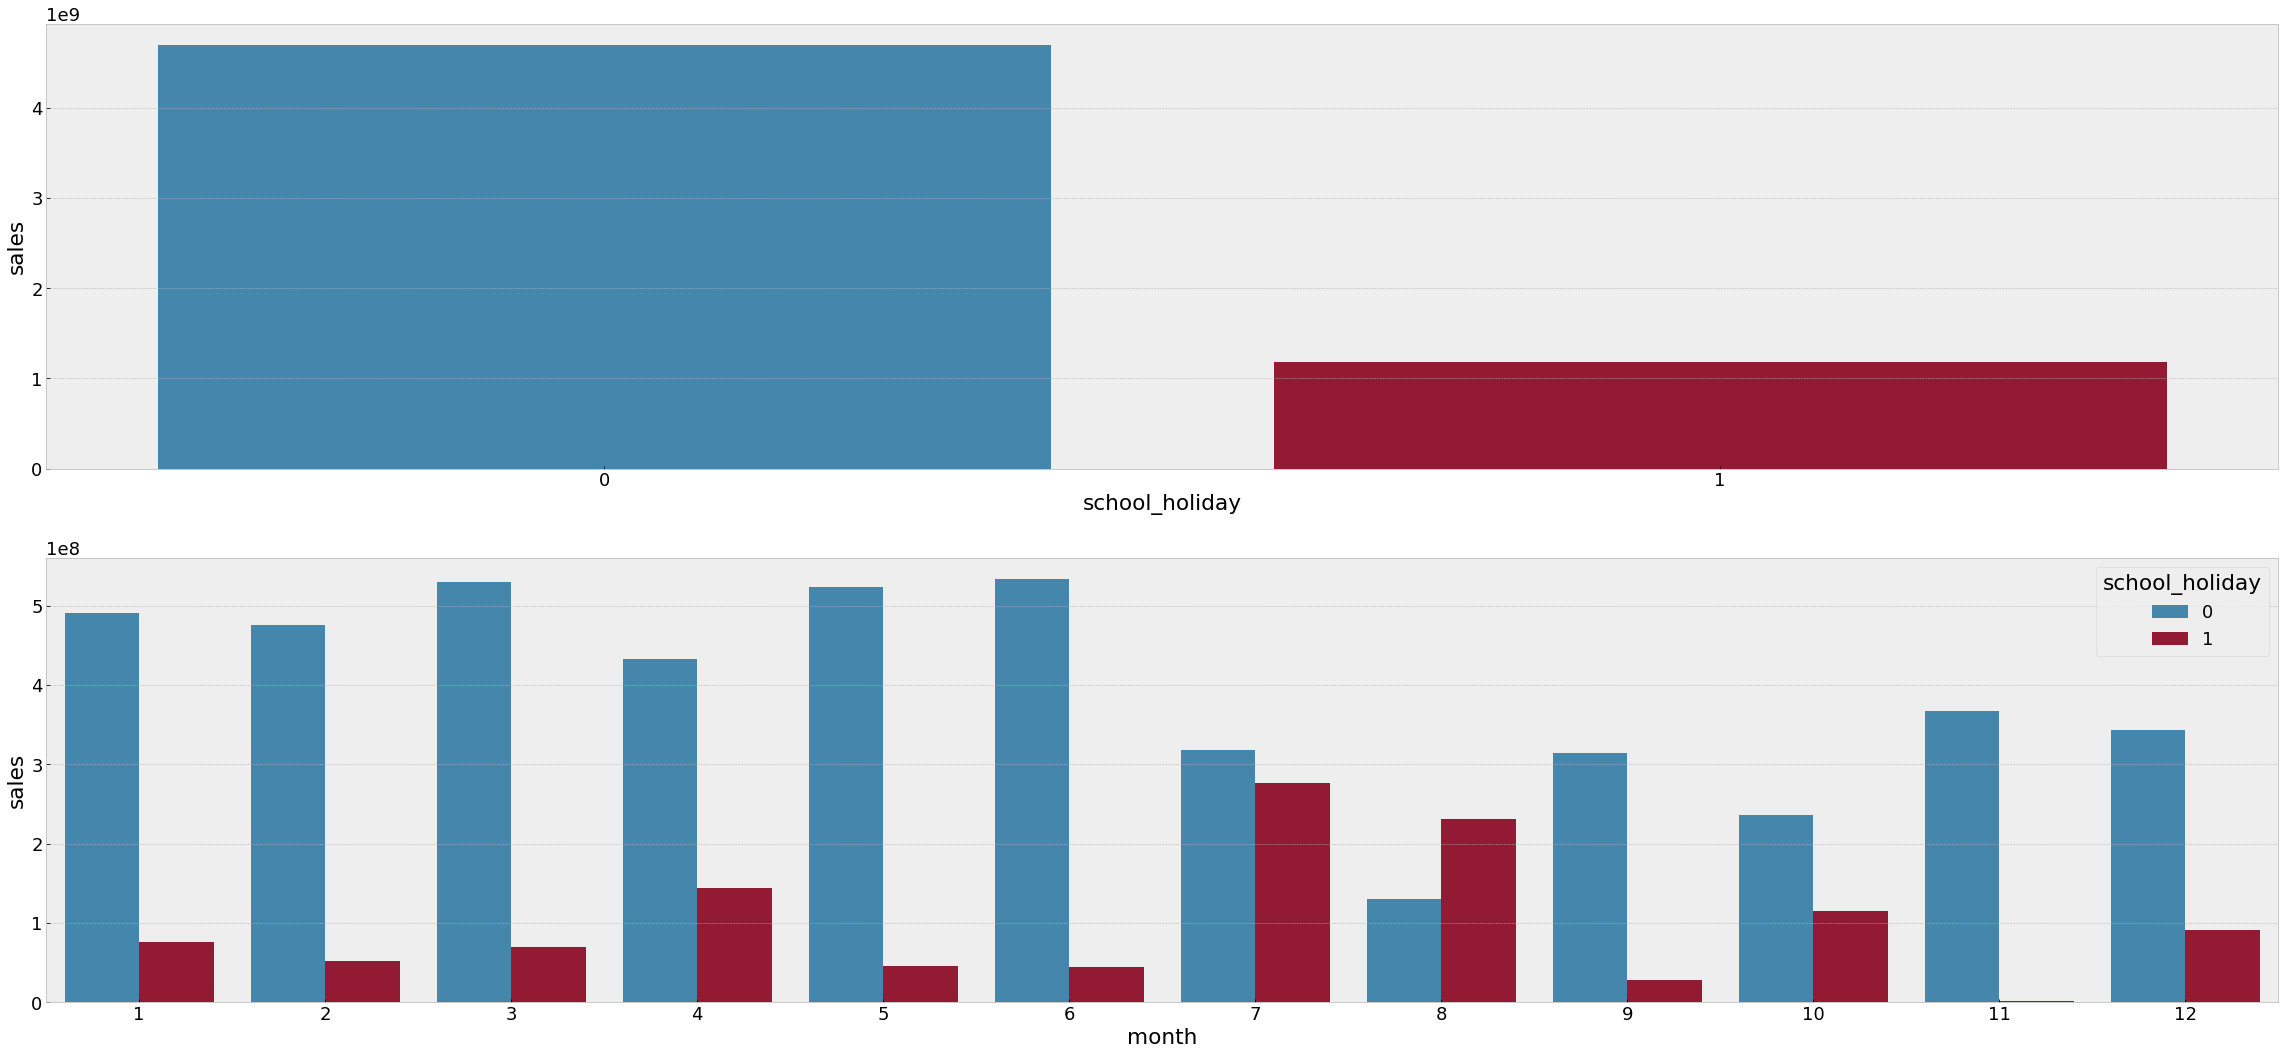

In [79]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot( 2 , 1, 1 )
sns.barplot( x= 'school_holiday', y= 'sales', data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x= 'month', y= 'sales', hue = 'school_holiday', data=aux2);

## 4.2.1.Resumo das hipoteses 

In [37]:
from tabulate import tabulate

In [38]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

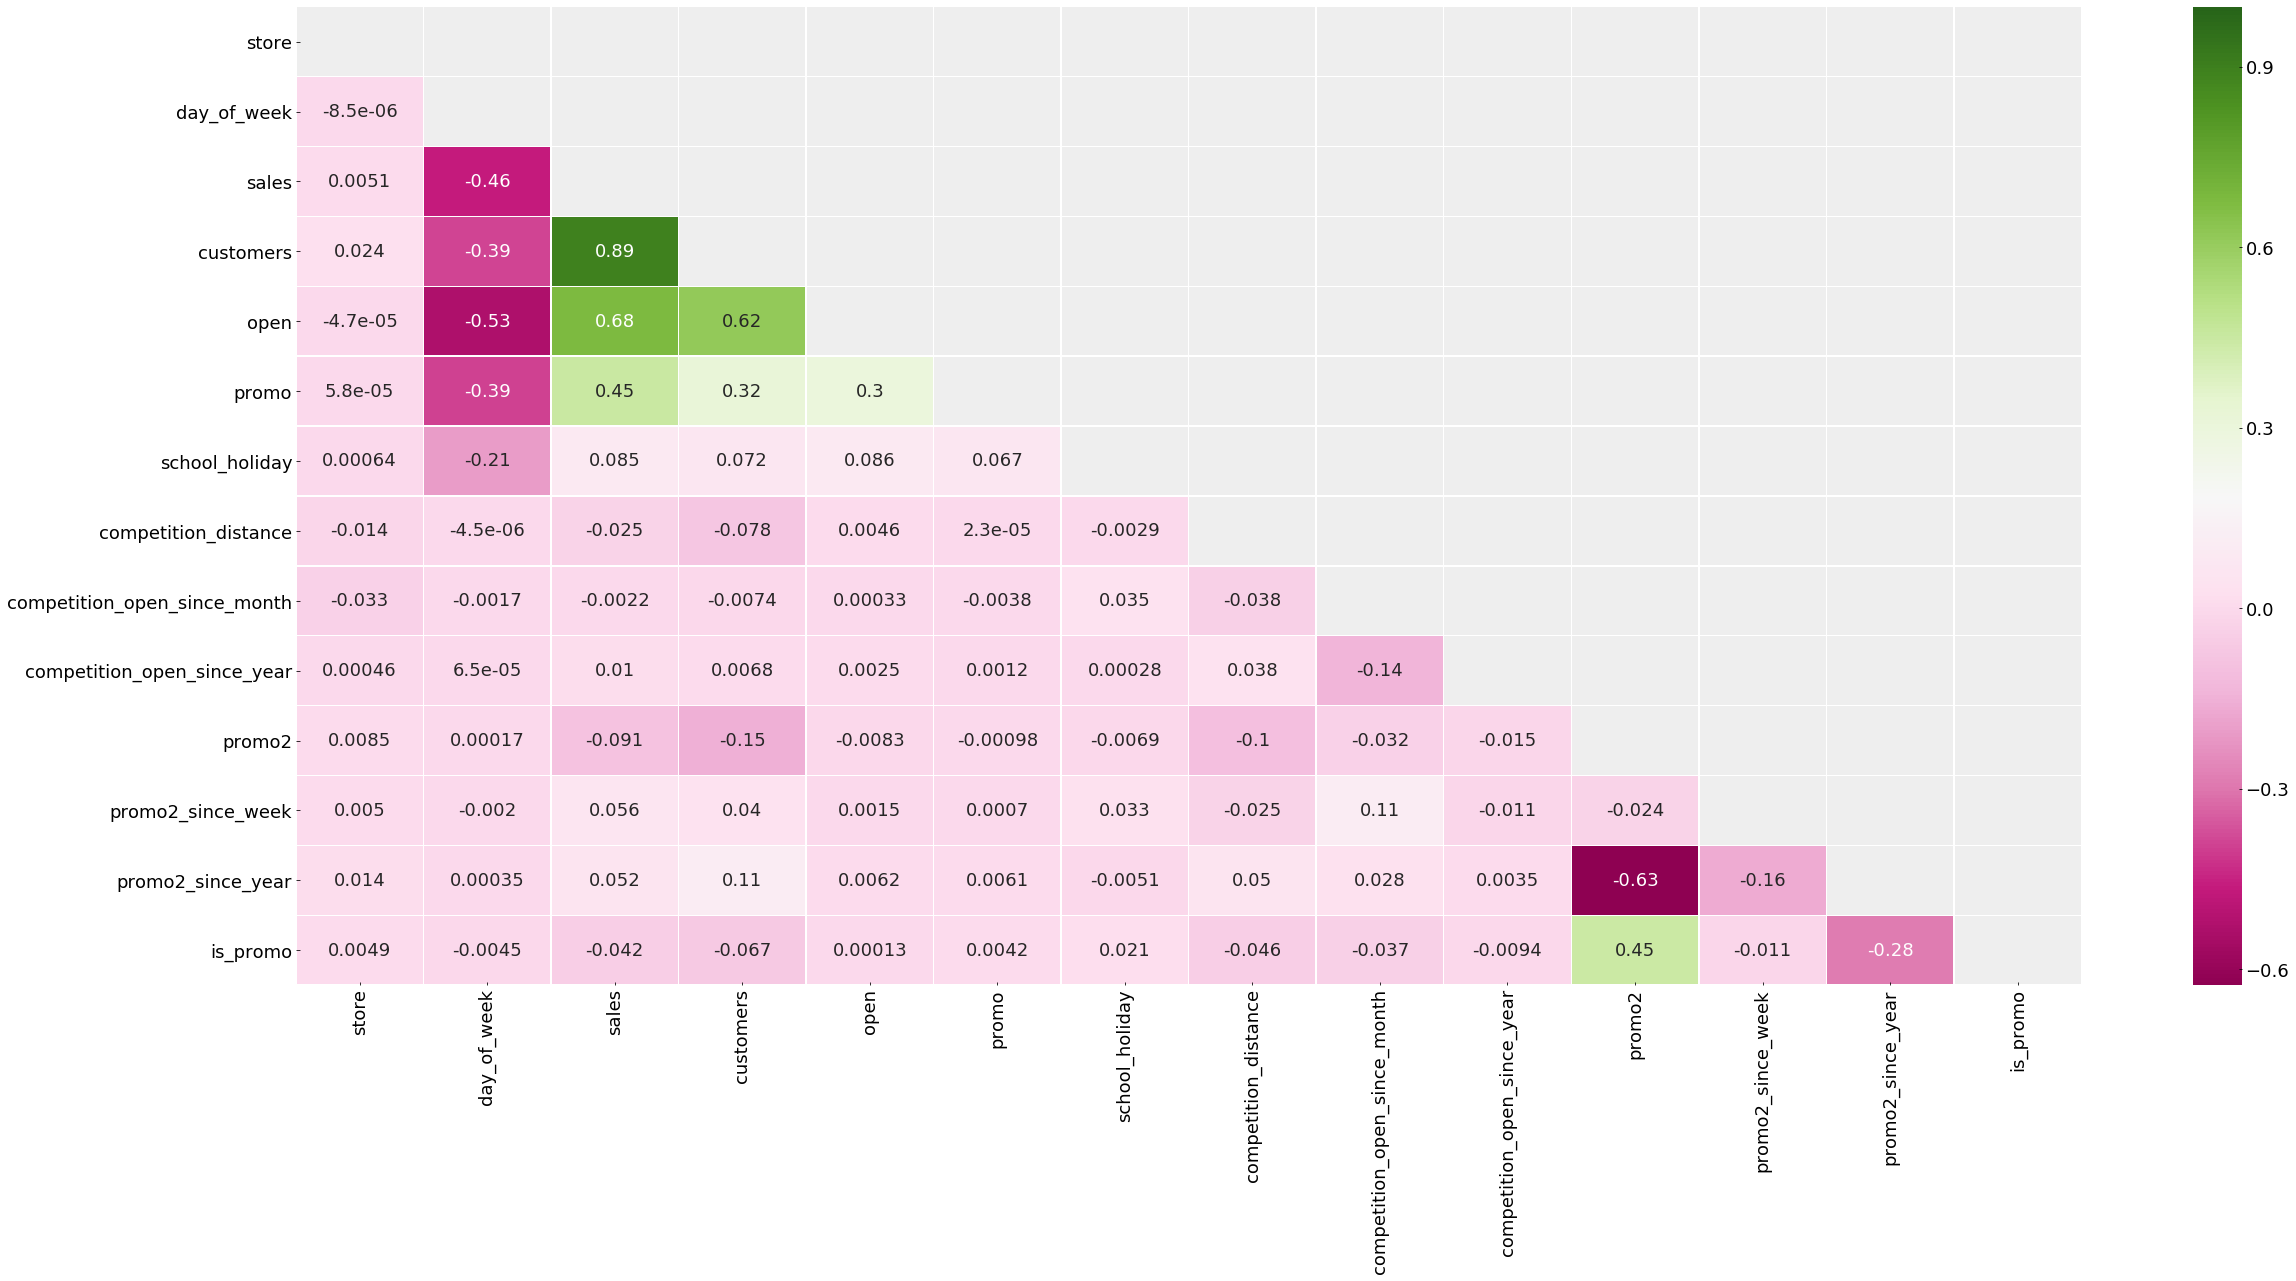

In [82]:
correlation = num_attributes.corr( method= 'pearson')

# getting upper triangle from correlation matrix
matrix = np.triu(correlation)

sns.heatmap( correlation, annot= True, mask= matrix, cmap= "PiYG", linewidth=.5);

### 4.3.2. Categorical Attributes

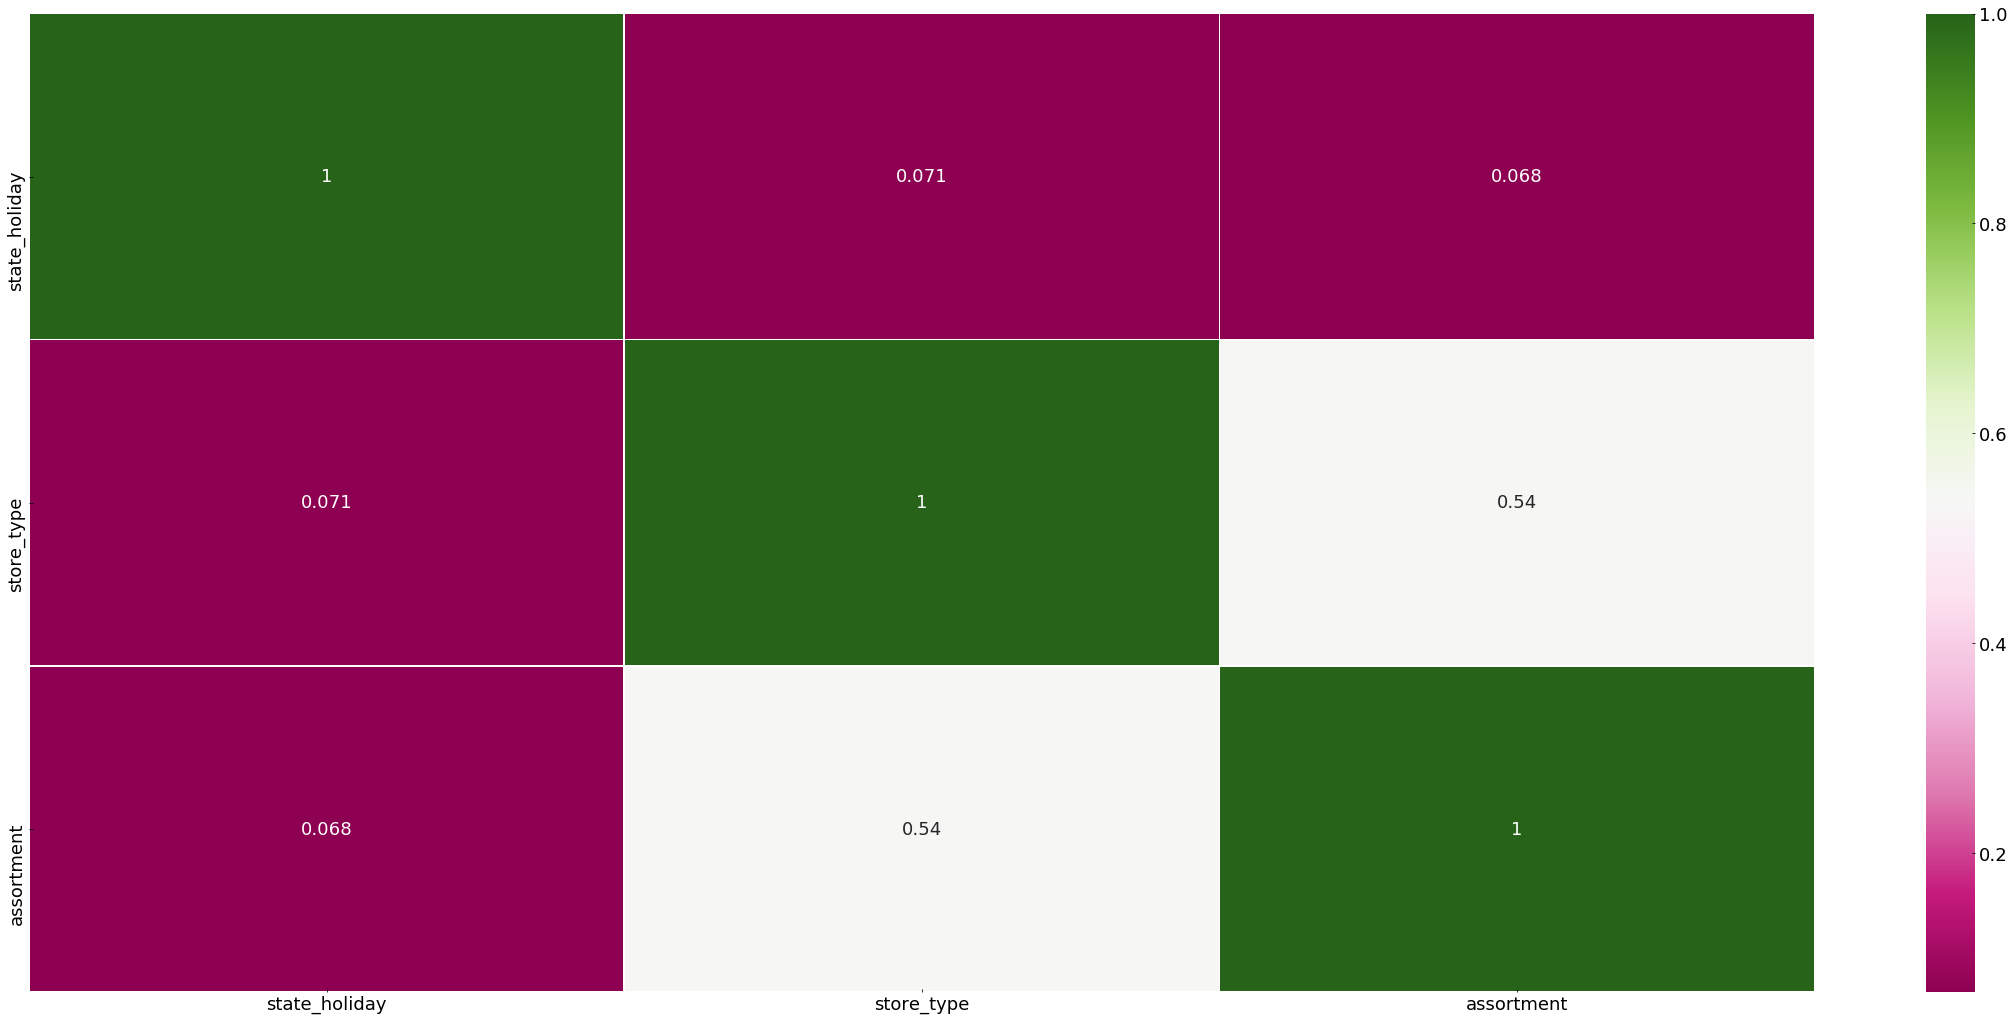

In [83]:
# only categorical data
a = df4.select_dtypes( include= 'object' )

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

sns.heatmap(d, annot=True , cmap= "PiYG", linewidth=.5);

# 5.0. PASSO 05 : DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalizacao

In [32]:
# Nota-se que não há variáveis com distribuição normal, logo, não será aplicada a Normalização nos dados.

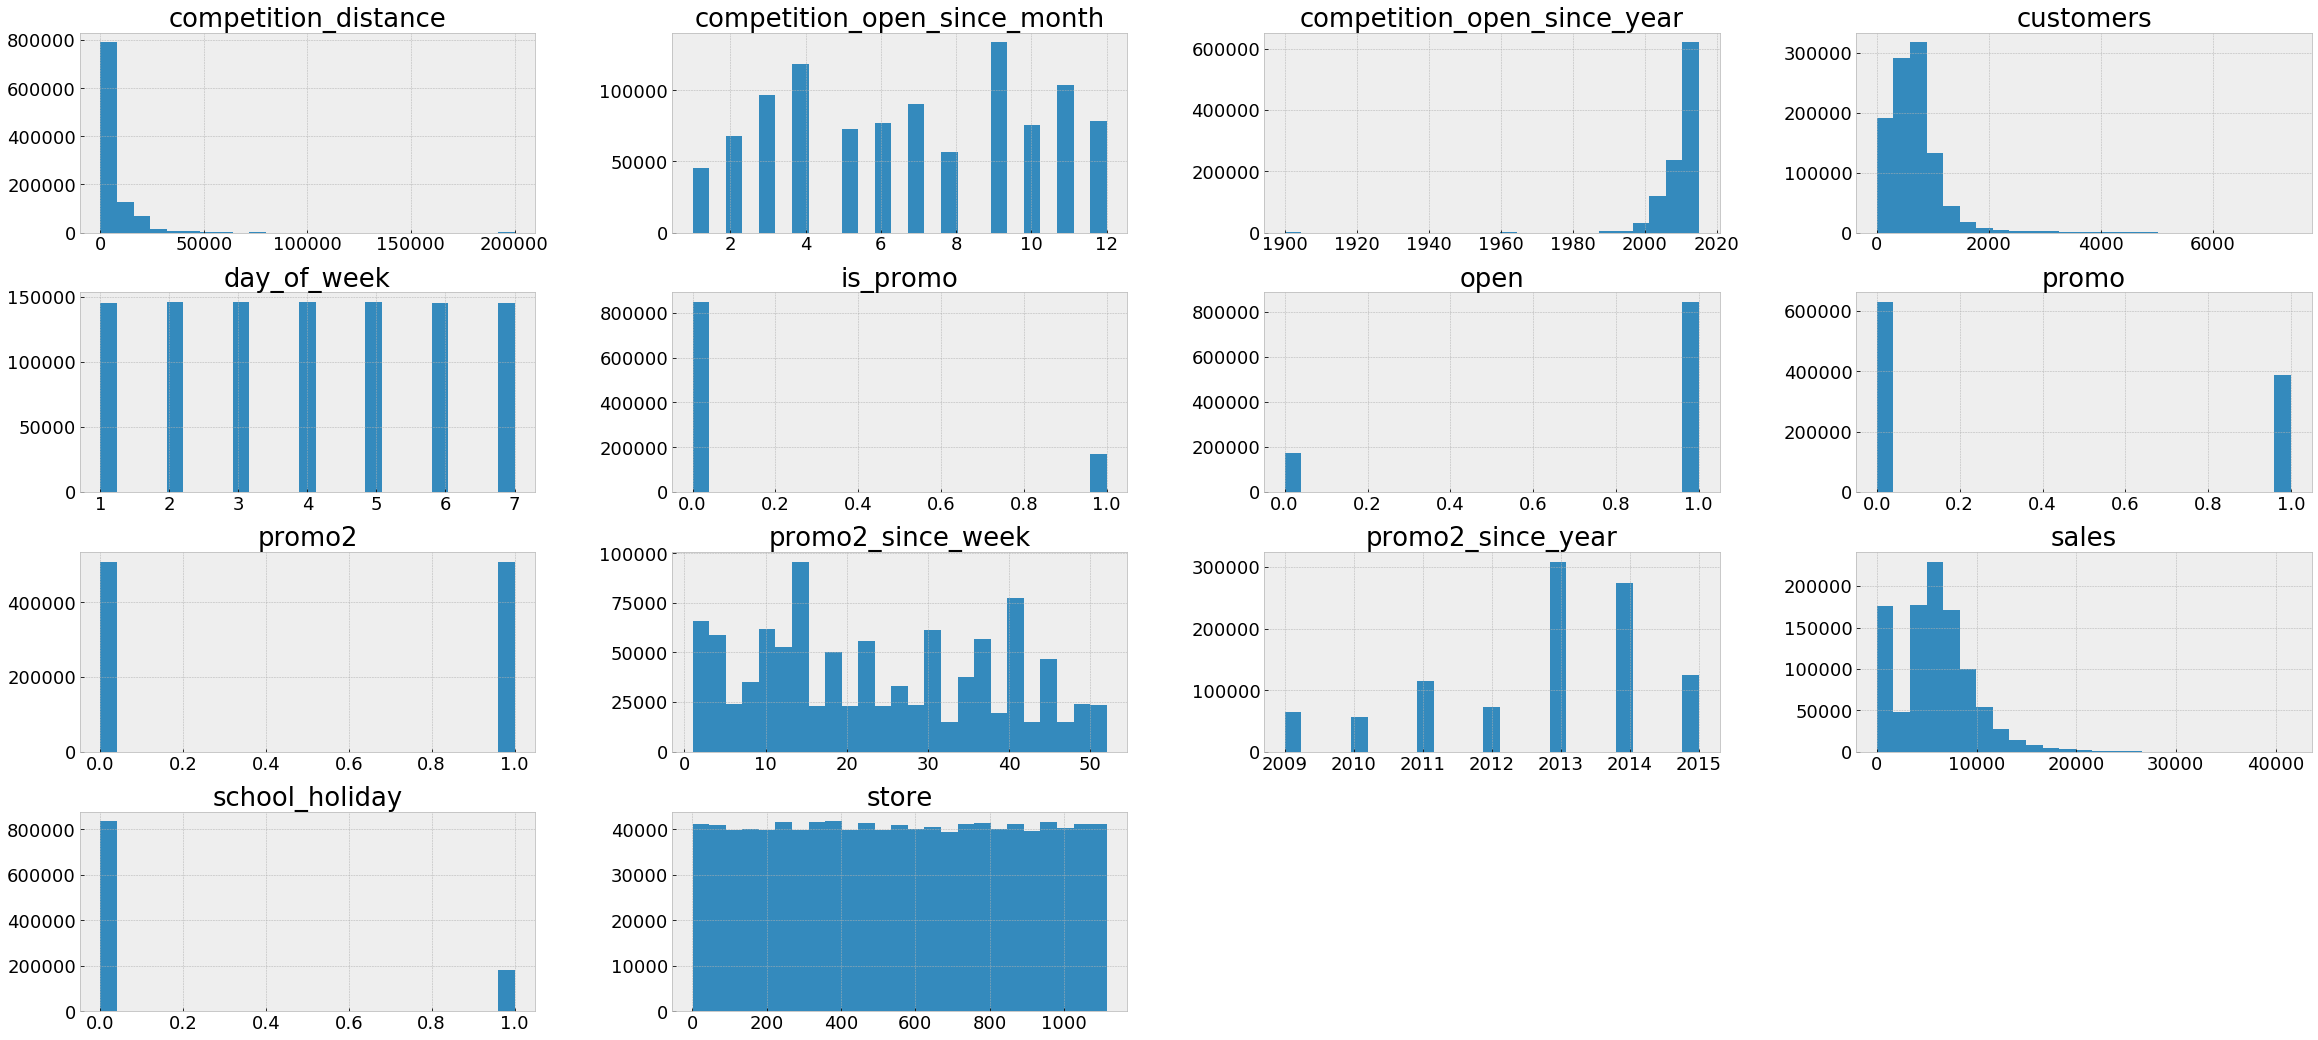

In [33]:
num_attributes.hist( bins = 25 );

## 5.2. Rescaling

In [34]:
# as variaveis com maior range acabam sendo priorizadas pelos algoritmos o que pode não ser verdade. Necessidade de igualar o range.

In [53]:
# Entender quais variaveis precisam ser rescaladas

# Convertendo os tipos int32 para int64)
df5 = df5.astype({'competition_open_since_month': np.dtype('int64'),
                  'competition_open_since_year': np.dtype('int64'),
                  'promo2_since_week': np.dtype('int64'),
                  'promo2_since_year': np.dtype('int64'),
                  'competition_time_month': np.dtype('int64'),
                  'promo_time_week': np.dtype('int64')})
df5.dtypes

    
a = df5.select_dtypes( include=['int64','float64'])

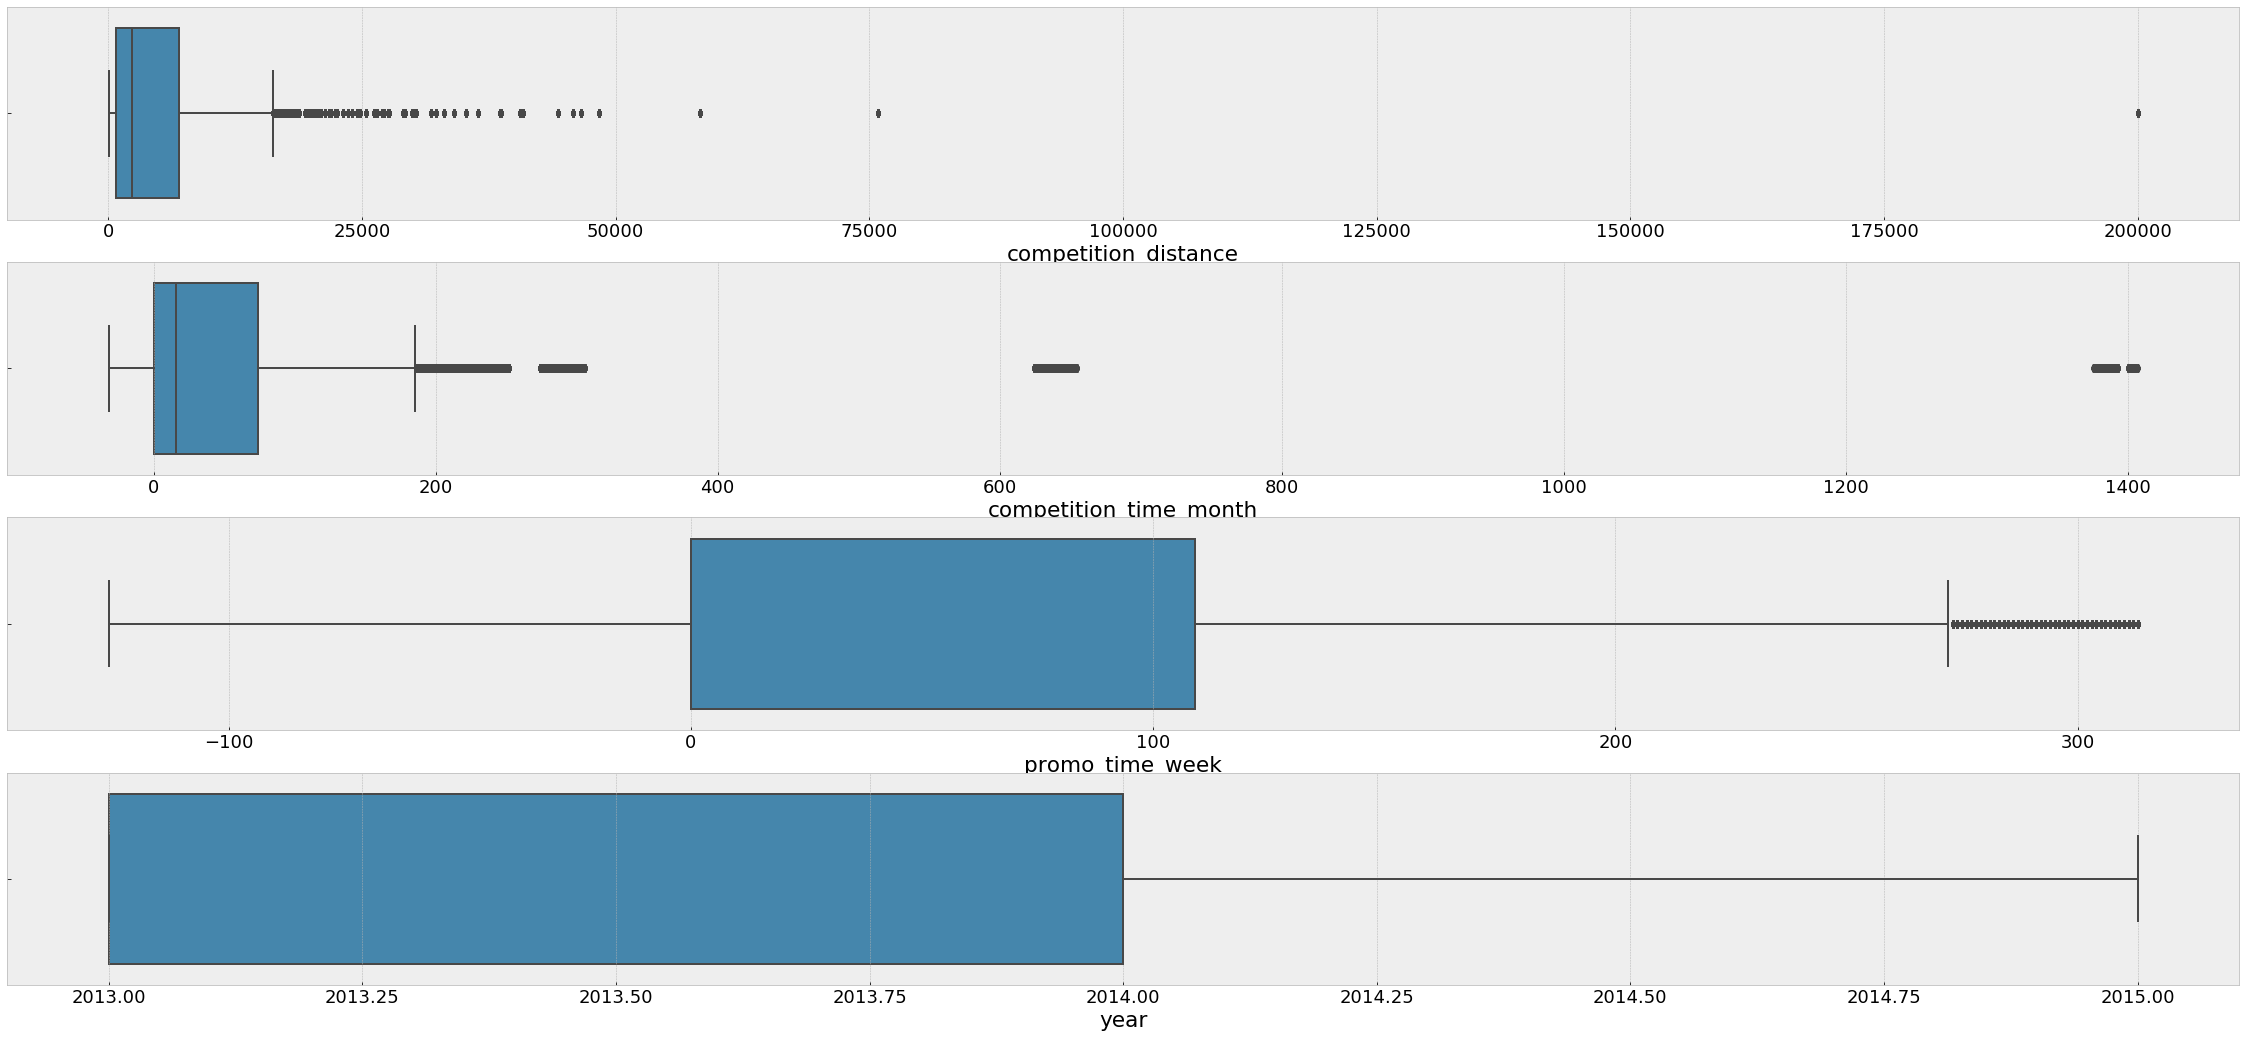

In [36]:

# Nota-se a presença de alguns outliers, logo usarei o Robust Scaler

plt.subplot( 4, 1, 1 )
sns.boxplot(a['competition_distance']);

plt.subplot( 4, 1, 2 )
sns.boxplot(a['competition_time_month']);

# Outliers não tão relevantes, uso do MinMaxScaler
plt.subplot( 4, 1, 3 )
sns.boxplot(a['promo_time_week']);

plt.subplot( 4, 1, 4 )
sns.boxplot(a['year']);

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# Fit transform : encontra os parametros da coluna e ja aplica a formula (localizando os quartis Q1 e Q3)
# Fit só encontra os parametros

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump(mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.3. Transformação

### 5.3.1. Encoding : variaveis categoricas que precisam transformar em numericas para o algoritmo poder aprender

In [55]:
# state_holiday : por ser um "estado", uso da OneHotEncoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# story_type : nao ha uma ordem definida ou relacao de importancia, uso da LabelEncoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb' ) )

# assortment : ha uma ordinalidade nos valores (basic < extra < extended), uso da OrdinalEncoding
assortment_dict = {'basic':1 , 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [31]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day'],
      dtype='object')

### 5.3.2. Response Variable Transformation

In [56]:
df5['sales'] = np.log1p( df5['sales'] )

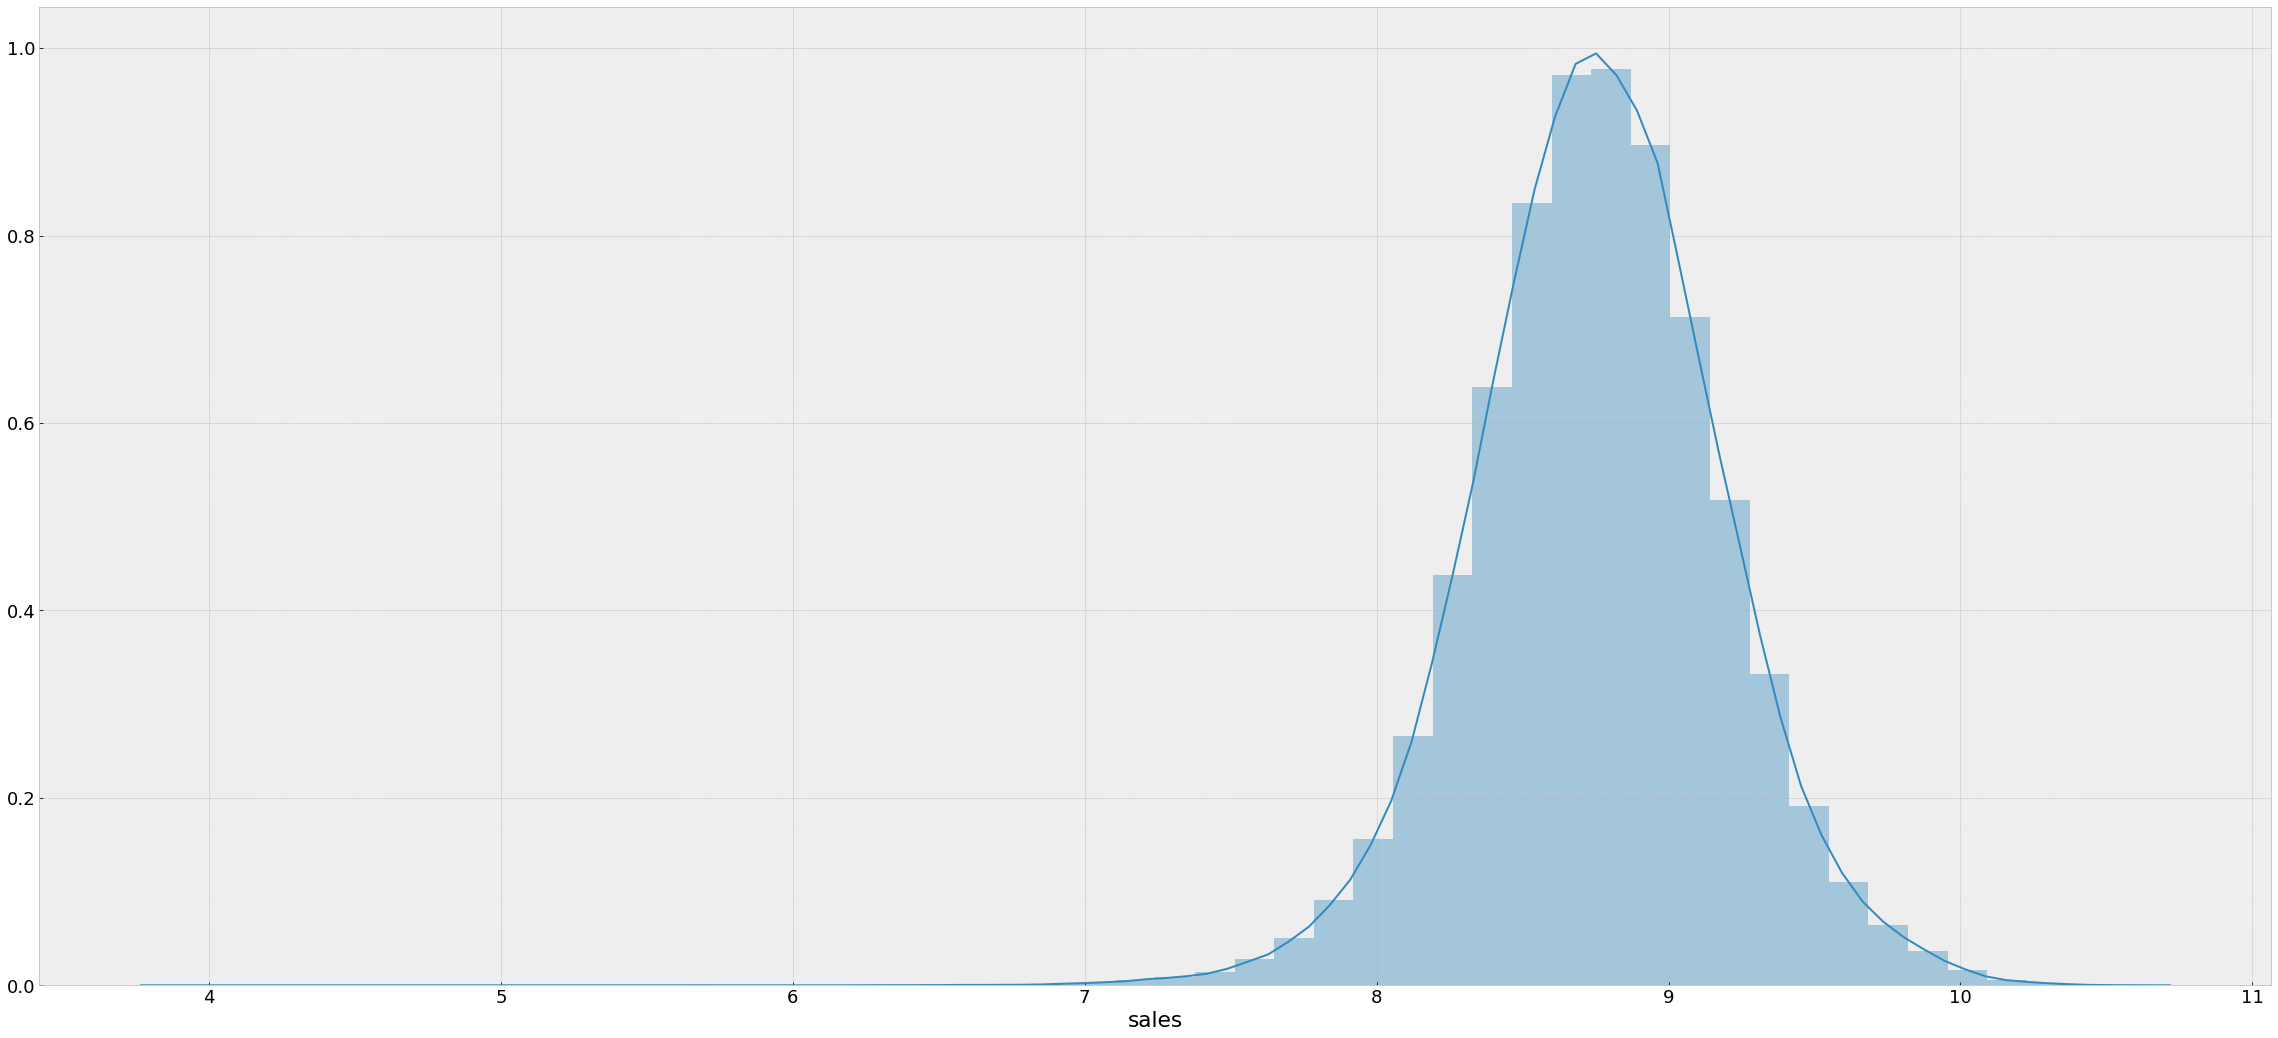

In [27]:
sns.distplot( df5['sales'])

### 5.3.3. Nature Transformation

In [91]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [57]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) ) 

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) ) 
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) ) 

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) ) 
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) ) 



In [93]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 PASSO 06 - FEATURE SELECTION

In [58]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [59]:
# deletando colunas que foram derivadas para outras

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [37]:
# coletar as últimas 6 semanas como teste (considerando o período que queremos prever) 
# todas as anteriores como treino

df6[[ 'store', 'date' ]].groupby( 'store' ).min().reset_index()
# aparentemente todas as lojas começaram no mesmo dia

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [38]:
df6[[ 'store', 'date' ]].groupby( 'store' ).max().reset_index()
# Encontrando o dia mais recente dos dados

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [31]:
df6[[ 'store', 'date' ]].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )
# Encontrando a data que separa os dados de treino / teste.

Timestamp('2015-06-19 00:00:00')

In [60]:
# até o dia 18-06-2015 vão ser os dados de treino
# A partir do dia 19-06-2015 vão ser os dados de teste

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}' .format( X_train['date'].min() ) )
print( 'Training Max Date: {}' .format( X_train['date'].max() ) )

print( '\nTest Min Date: {}' .format( X_test['date'].min() ) )
print( 'Test Max Date: {}' .format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [70]:
# parametros : modelo a ser usado -> rf (random forest);
# verbose para ir plotando as informacoes q estiverem sendo processadas
# random_state= 42 (numero fixo para cravar o "inicio" dos valores aleatórios)

In [71]:
# define RandomForestRegressor : parametros (para usar todos os cores da máquina e criar as árvores em paralelo, sendo mais rápido )
rf = RandomForestRegressor( n_jobs=-1 )

# training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1 ).values

# ravel() para colocar os valores em um vetor
y_train_n = y_train.values.ravel()

# Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

KeyboardInterrupt: 

### 6.2.1. Best Features from Boruta

In [ ]:
# support para identificar os ranks criados para cada variável

cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# O que tenho nas minhas variáveis que nao foi selecionado pelo boruta
cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns , cols_selected_boruta ) )

## 6.3. Manual Features Selection

In [41]:
# selecionar os senos dos cossenos q foram considerados relevantes como relevantes também.

# Comparar com o tabulate do EDA que foi feito
    # - Grande parte das hipóteses foram acertadas

In [61]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [41]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [42]:
X_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Prepararation

x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [44]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions' })

aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [45]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction 
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [46]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


In [40]:
# RMSE, o erro é muito maior que o modelo de média:
# - O modelo de media é melhor que o modelo de regressão linear
# - Os dados possuem comportamento complexo (não-linear).

## 7.3. Linear Regression Regularized Model - Lasso

In [41]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict ( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso (Linear Regression Regularized) - Cross Validation

In [42]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [43]:
# model
# n_jobs = -1 para rodar em paralelo
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict ( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.09996,1011.191561


### 7.4.1. Random Forest Regressor - Cross Validation

In [44]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5 XGBoost Regressor

In [63]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict ( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,857.809468,0.125117,1260.20886


### 7.5.1. XGBoost Regressor - Cross Validation

In [46]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\Pichau\anaconda3\envs\datascienceemproducao\lib\site-packages\xgboost\core.py:5

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [47]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )

modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,XGBoost Regressor,857.809468,0.125117,1260.208860
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [48]:
# O valor do erro (RMSE) não é o valor correto para medição de performance. É necessário realizar alguns testes.
# testar o algoritmo sobre um período maior, para garantir que o teste não tenha um resultado ao acaso.

### 7.6.2. Real Performance

In [49]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [64]:
import random
import warnings

warnings.filterwarnings( 'ignore' )

In [48]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [52]:
#final_result = pd.DataFrame()
##max eval -> constante que passa pelo maior numero de iterações possível
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])
#
#    
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat( [final_result, result])
#    
#final_result

## 8.2. Final Model

In [65]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 15
}


In [51]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,636.462214,0.092111,924.744571


In [52]:
mpe = mean_percentage_error( np.expm1( y_test) , np.expm1( yhat_xgb_tuned ) )

mpe

0.007725923253578629

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-99-bce4c8aa9429>, line 1)

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [54]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale

df9['sales'] = np.expm1(df9['sales'])

df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [55]:
# Sum of predictions

df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')

df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [76]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
539,540,247043.203125,246369.298538,247717.107712,673.904587,0.093879
85,86,172275.703125,171756.151011,172795.255239,519.552114,0.123164
829,830,224758.640625,224231.331952,225285.949298,527.308673,0.077865
834,835,206408.265625,206014.267921,206802.263329,393.997704,0.083191


In [79]:
df92.sort_values( 'MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106572.554688,103313.090473,109832.018902,3259.464214,0.559394
908,909,244246.890625,236851.410623,251642.370627,7395.480002,0.502758
875,876,203412.562500,199501.641708,207323.483292,3910.920792,0.294429
594,595,391112.968750,387380.535565,394845.401935,3732.433185,0.262390
721,722,349243.656250,347353.179397,351134.133103,1890.476853,0.253752
...,...,...,...,...,...,...
634,635,218233.812500,217934.786100,218532.838900,299.026400,0.055335
380,381,330682.406250,330203.142116,331161.670384,479.264134,0.053937
258,259,539379.062500,538712.619209,540045.505791,666.443291,0.052412
1096,1097,454348.781250,453880.701569,454816.860931,468.079681,0.043691


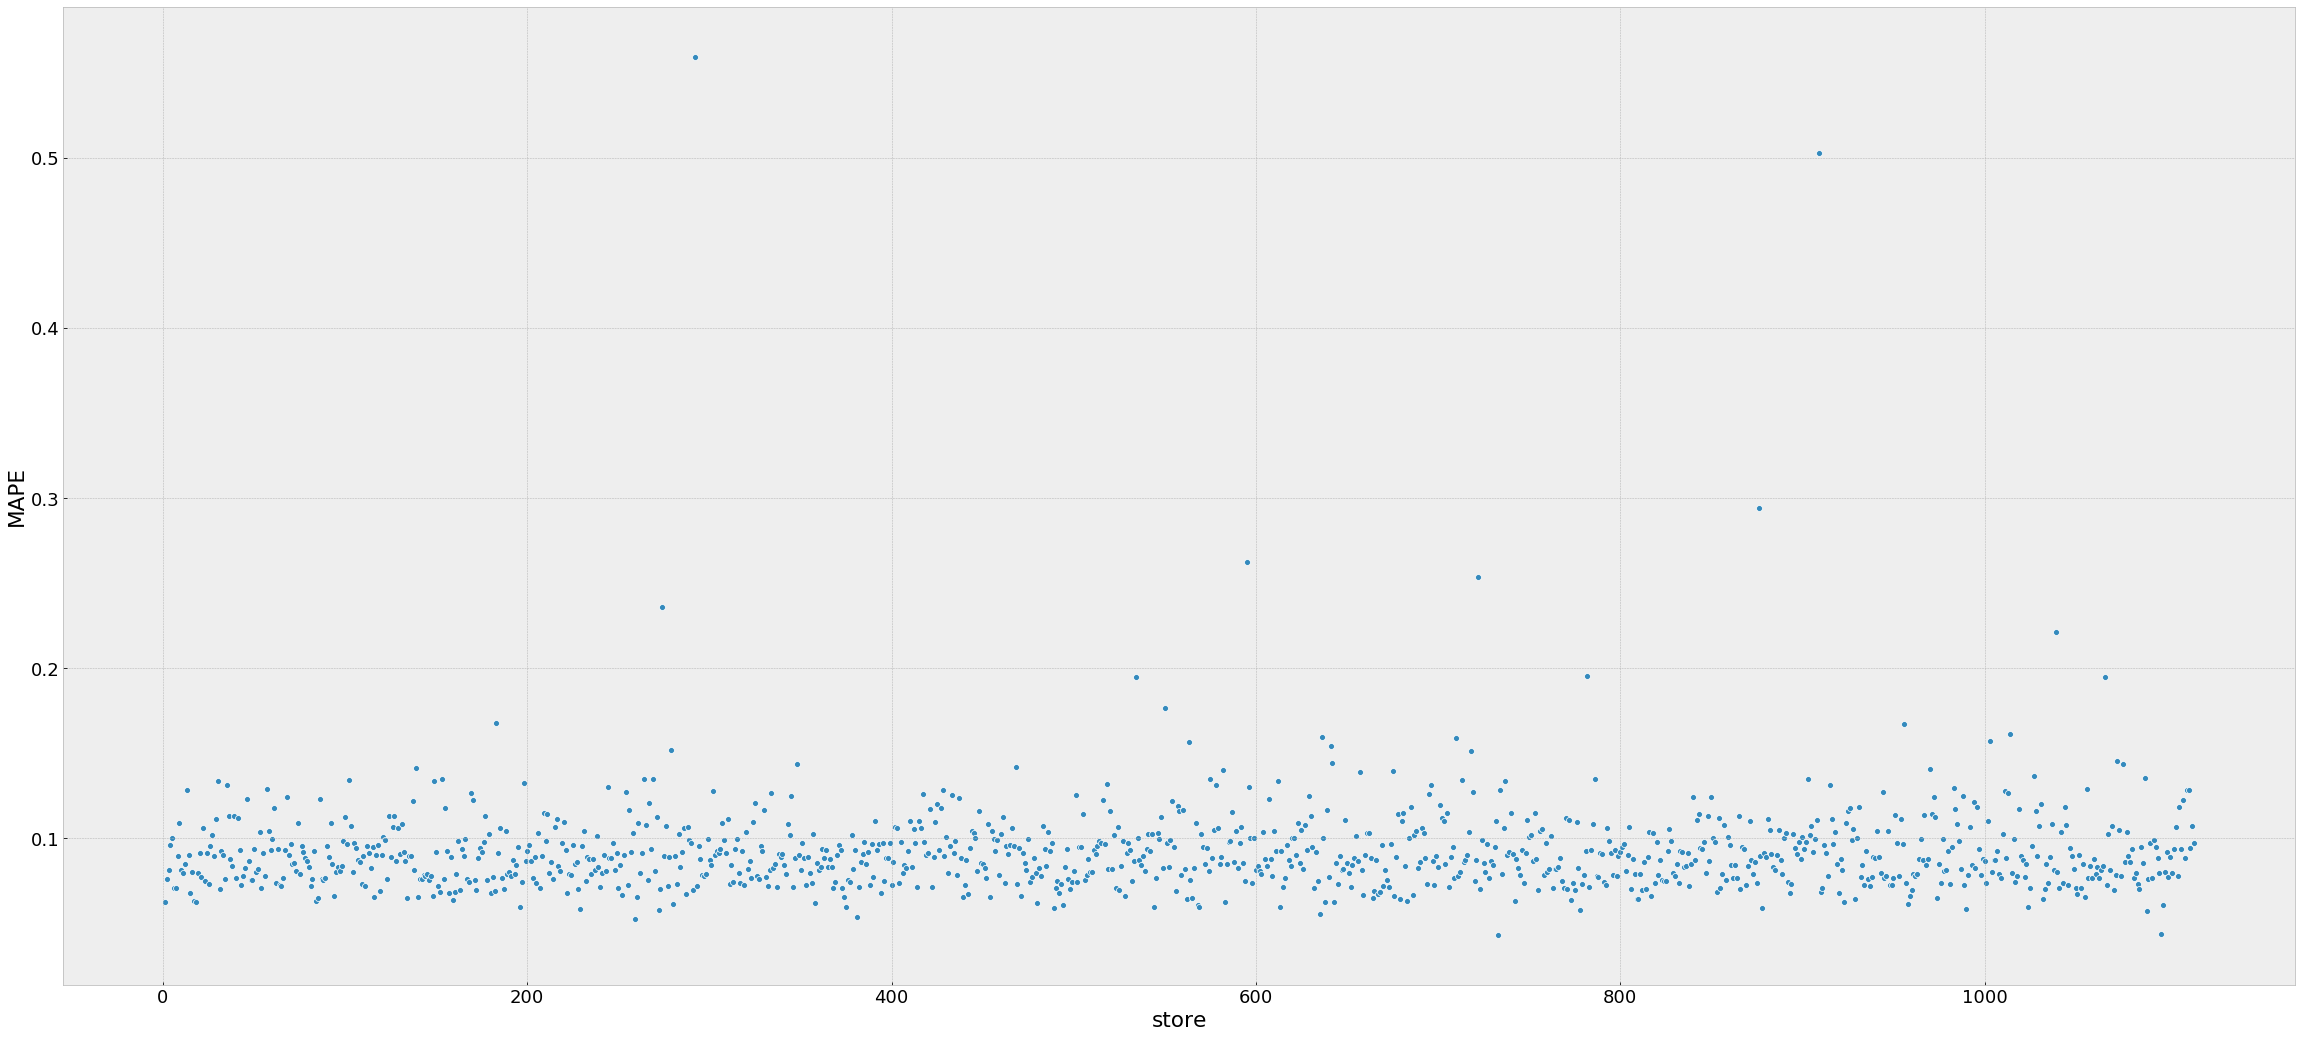

In [82]:
sns.scatterplot( x='store', y='MAPE', data= df92);

## 9.2. Total Performance

In [84]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis= 0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'} )

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)

df93

,Scenario,Values
0,predictions,"R$283,569,357.72"
1,worst_scenario,"R$282,855,492.36"
2,best_scenario,"R$284,283,223.08"


## 9.3. Machine Learning Performance

In [86]:
df9['error'] = df9['sales'] - df9['predictions']

df9['error_rate'] = df9['predictions'] / df9['sales']

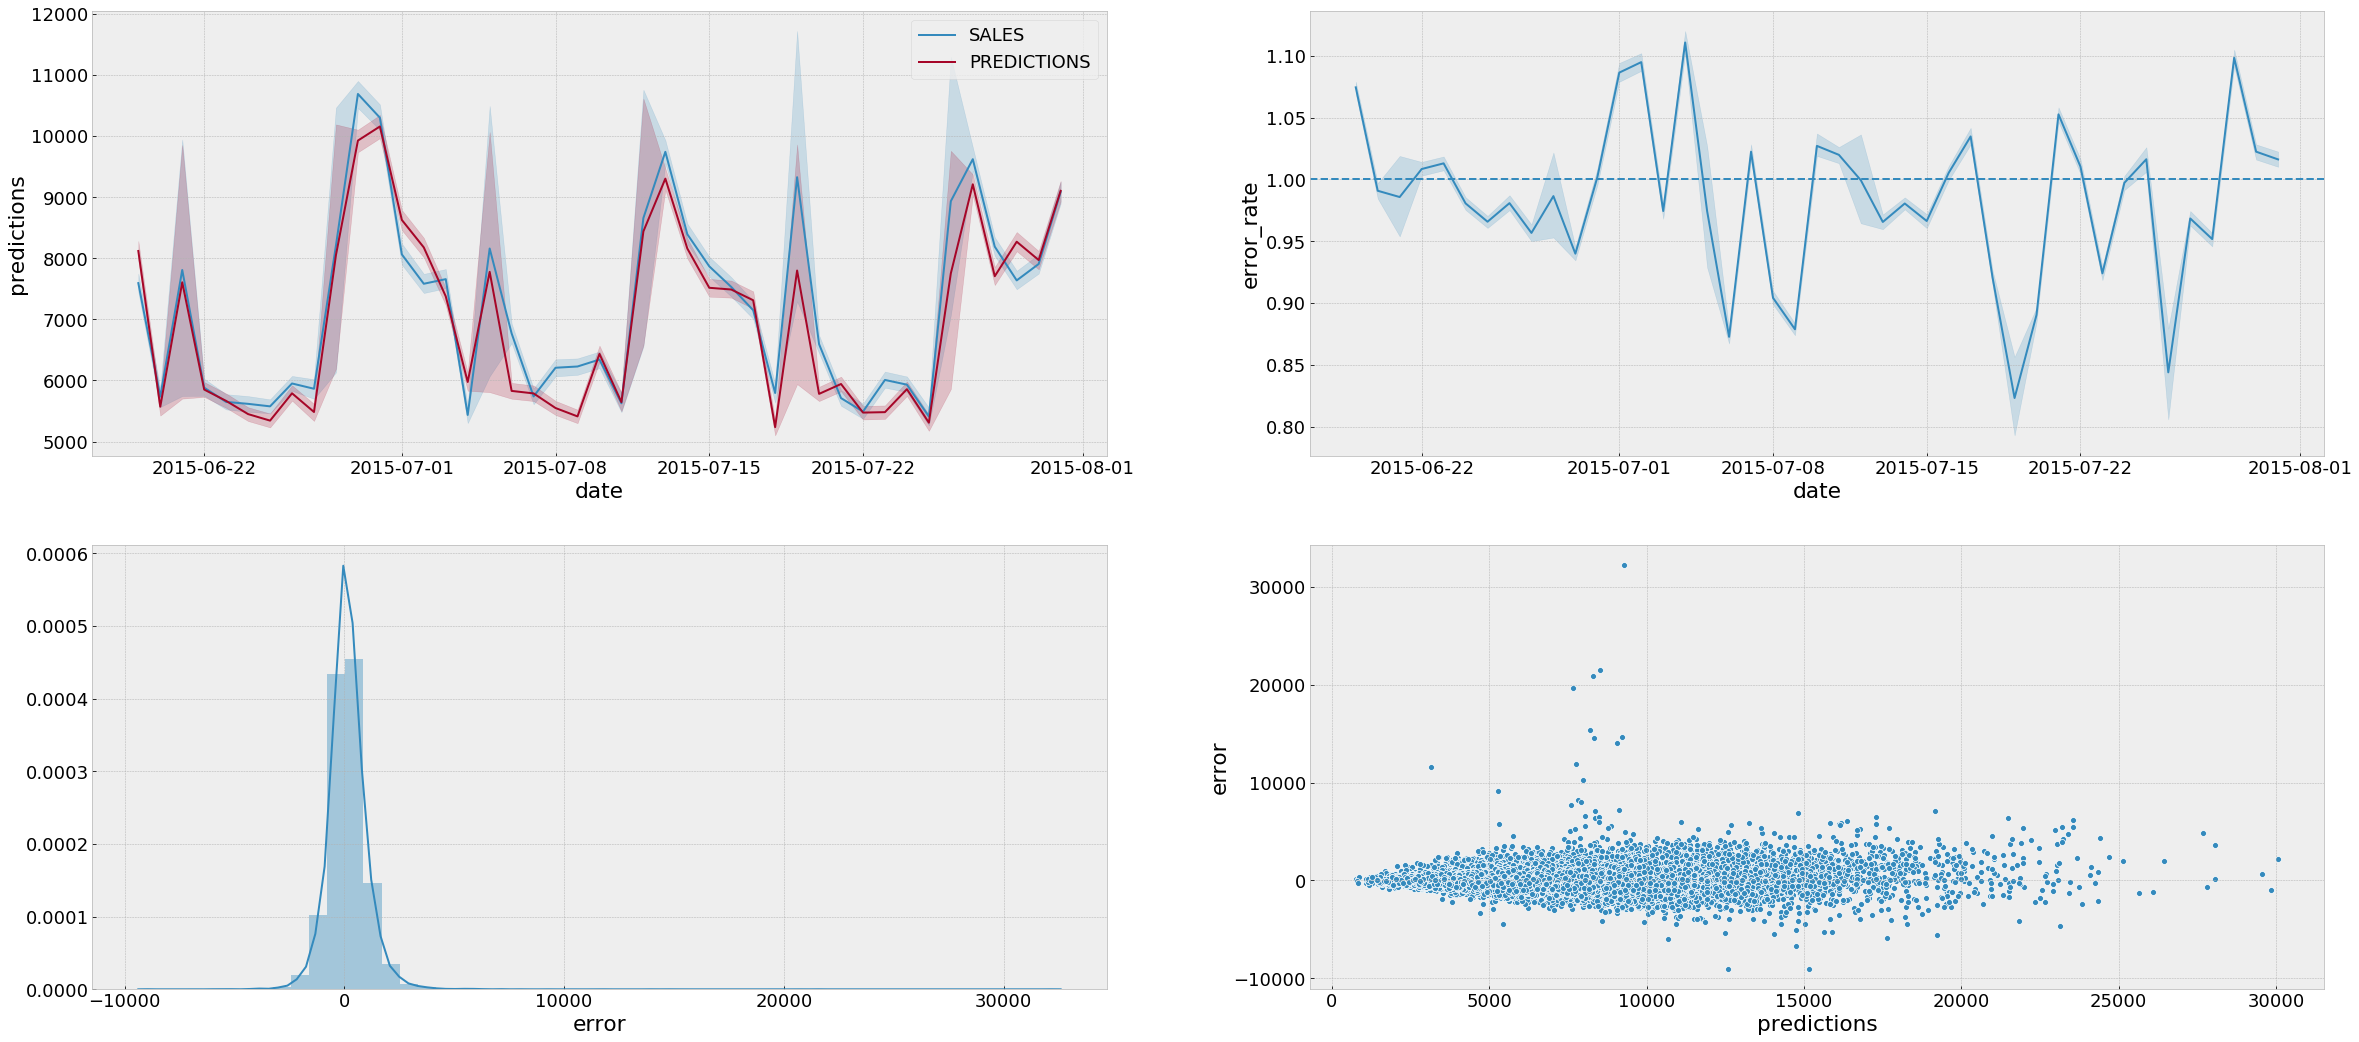

In [88]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

# analise de residuos
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

# PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('/Users/Pichau/DataScience -repos]DS_em_producao/model/model_rossmann.pkl','wb'))

## 10.1. Rossmann Class

In [85]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/Users/Pichau/DataScience -repos/DS_em_producao/'
        self.competition_distance_scaler         = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler       = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler              = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                         = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler                   = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )
        
        state = 1
        
    def data_cleaning( self, df1 ):
        ## 1.1. Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list(map( snakecase, cols_old ))
        
        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True)
        
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
        
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) / 7).apply( lambda x: x.days ).astype(int)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x :'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        
        # 3.0. PASSO 03 : FILTRAGEM DE VARIÁVEIS
        
        
        ## 3.1. Filtragem das Linhas
        
        # vendas cujas lojas estavam abertas
        df2 = df2[(df2['open'] != 0)]
        
        ## 3.2. Seleção das Colunas
        
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        
        # as variaveis com maior range acabam sendo priorizadas pelos algoritmos o que pode não ser verdade. Necessidade de igualar o range.
        
        # Entender quais variaveis precisam ser rescaladas
        
        # Convertendo os tipos int32 para int64)
        df5 = df5.astype({'competition_open_since_month': np.dtype('int64'),
                          'competition_open_since_year': np.dtype('int64'),
                          'promo2_since_week': np.dtype('int64'),
                          'promo2_since_year': np.dtype('int64'),
                          'competition_time_month': np.dtype('int64'),
                          'promo_time_week': np.dtype('int64')})
        
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
        
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )
        
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values )
        
        
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values )
        
        
        ## 5.3. Transformação
        
        ### 5.3.1. Encoding : variaveis categoricas que precisam transformar em numericas para o algoritmo poder aprender
        
        # state_holiday : por ser um "estado", uso da OneHotEncoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
        
        # story_type : nao ha uma ordem definida ou relacao de importancia, uso da LabelEncoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'])
        
        
        # assortment : ha uma ordinalidade nos valores (basic < extra < extended), uso da OrdinalEncoding
        assortment_dict = {'basic':1 , 'extra': 2, 'extended': 3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        
        ### 5.3.3. Nature Transformation
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) ) 
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) ) 
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) ) 
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) ) 
        
        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) ) 
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) ) 
        
        cols_selected = [
                         'store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos']

        
        return df5[ cols_selected ]
                  
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
                  
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
                  
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [29]:
# biblioteca Flask : conjunto de funções para lidar com o ambiente Web (requisições, devoluções, manter endpoint funcionando... )
# '0.0.0.0' = local host
# methods -> POST ou GET
#    - POST : métodos em que é enviado dados para poder receber
#     - GET : método em que é pedido alguma coisa

In [71]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/Pichau/DataScience -repos/DS_em_producao/model/model_rossmann.pkl', 'rb' ) )

app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
     
    if test_json: # there is data
        if isinstance( test_json, dict ): # Unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # Multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status= 200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [114]:
import requests

In [115]:
# loading test dataset
df10 = pd.read_csv( '/Users/Pichau/DataScience -repos/DS_em_producao/data/test.csv')

In [122]:
# merge test dataset + store

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([15,22,54])]

# remove closed days

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [123]:
# Convert dataframe to json

data = json.dumps( df_test.to_dict( orient='records' ))

In [124]:
# API Call
# url = 'http://192.168.56.1:5000/rossmann/predict'
url = 'https://teste-rossmann-api-pxuy.onrender.com/rossmann/predict'
header = { 'Content-type' : 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [125]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [126]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range (len ( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks.'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store Number 15 will sell R$273,029.65 in the next 6 weeks.
Store Number 22 will sell R$179,203.70 in the next 6 weeks.


In [127]:
data

'[{"Store": 15, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 4110.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2010.0, "Promo2": 1, "Promo2SinceWeek": 14.0, "Promo2SinceYear": 2011.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 15, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 4110.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2010.0, "Promo2": 1, "Promo2SinceWeek